# Registration of Sentinel-2 with NAIP 2019

### Import Packages

In [1]:
# Import packages

from pathlib import Path
from arosics import COREG, COREG_LOCAL, DESHIFTER
from geoarray import GeoArray
from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt
import os

### Path Setup

In [2]:
# Set the working directory

wd = Path('/media/antonio/antonio_ssd/FORCE/corregistration')
#wd = Path('F:/FORCE/corregistration')
assert wd.exists()

### Load the Reference Image

In [3]:
# Select and read title of intest from NAIP

basemap_file = wd/'X0016_Y0024/NAIP_X0016_Y0024.tif' #This is the NAIP scene of 2019 for the title of interest
reference = GeoArray(str(basemap_file))

# Plot raster
# reference.show(figsize = (15, 15))

### Load Target Image

Note: array has been downsampled to 1000 x 1000 for faster visualization.


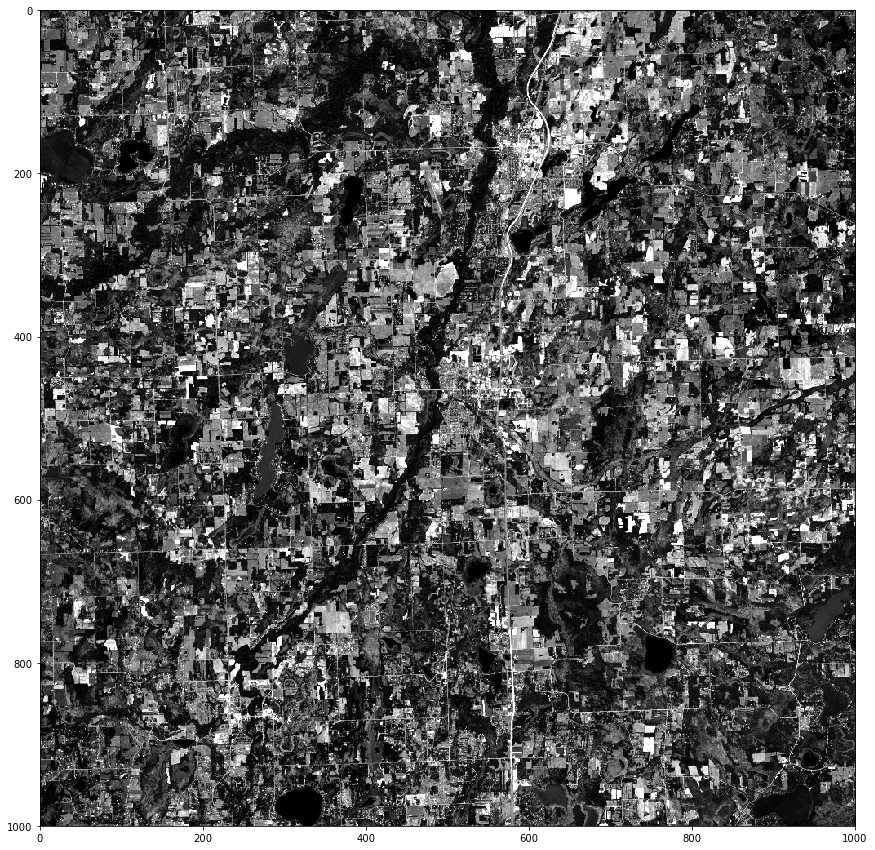

In [5]:
# Select and the image/title of interest from Sentinel-2

target_file = wd/'X0016_Y0024/X0016_Y0024_red.tif' #This is the average RED band for the groing period of 2019
target = GeoArray(str(target_file))

# Plot raster
target.show(figsize = (15, 15))

### Coregistration to a Basemap Image

In [6]:
# Sometimes the projections does not match. Let's force them to be the same regardless if they are equal.
if reference.projection == target.projection:
    reference.projection = target.projection
else:
    print("Stop, you need to check the projection to continue")    

In [7]:
# Setup parameters for tiepoint detection and affine transformation factor calculation
coreg_kwargs = {
    'grid_res': 100, # Tie point spacing in x-direction, in terms of target image pixels
    'window_size': (164, 164), # Size of matching window
    'nodata': (0.0, -9999), # No-data values for reference & target images
    'max_iter': 8,
    'r_b4match': 3, # Reference band for matching
    's_b4match': 1, # Target band for matching
    'CPUs': 24,      # For Ubuntu only
    'max_shift': 150,
    'min_reliability': 20
}

# Apply local image coregistration
CRL = COREG_LOCAL(reference, target, **coreg_kwargs)

# Inspect the result
CRL.correct_shifts()

Calculating footprint polygon and actual data corner coordinates for reference image...


Polygonize progress     |==================================================| 100.0% Complete  => 0:00:10
/home/antonio/.local/lib/python3.8/site-packages/geoarray/baseclasses.py:733: RuntimeWarning: Mean of empty slice
  if np.nanmean(bandmeans) == self.nodata:


Bounding box of calculated footprint for reference image:
	(194888.1532, 701064.19, 225888.3281, 730539.7613)
Calculating footprint polygon and actual data corner coordinates for image to be shifted...
Bounding box of calculated footprint for image to be shifted:
	(199292.51690292917, 705980.1870542851, 229292.51690292917, 735980.1870542851)
Matching window position (X,Y): 211875.34754871845/717938.1428489388
Initializing tie points grid...
Equalizing pixel grids and projections of reference and target image...


Warping progress     |==================================================| 100.0% Complete  => 0:00:01


Calculating tie point grid (618 points) using 24 CPU cores...


/home/antonio/.local/lib/python3.8/site-packages/arosics/CoReg.py:1178: RuntimeWarning: invalid value encountered in true_divide
  temp = np.array(fft_arr0 * fft_arr1.conjugate()) / (np.abs(fft_arr0) * np.abs(fft_arr1) + eps)
/home/antonio/.local/lib/python3.8/site-packages/arosics/CoReg.py:1178: RuntimeWarning: invalid value encountered in true_divide
  temp = np.array(fft_arr0 * fft_arr1.conjugate()) / (np.abs(fft_arr0) * np.abs(fft_arr1) + eps)
/home/antonio/.local/lib/python3.8/site-packages/arosics/CoReg.py:1417: RuntimeWarning: overflow encountered in short_scalars
  return ((array - minval) / (maxval - minval)).astype(np.float64)
	progress: |=-------------------------------------------------| 1.9% Complete  => 0:00:00/home/antonio/.local/lib/python3.8/site-packages/arosics/CoReg.py:1417: RuntimeWarning: overflow encountered in short_scalars
  return ((array - minval) / (maxval - minval)).astype(np.float64)
/home/antonio/.local/lib/python3.8/site-packages/arosics/CoReg.py:1178: R

In [8]:
with np.errstate(over = 'ignore', divide = 'ignore', invalid = 'ignore'): # Ignore AROSICS complaining
    result = CRL.correct_shifts()

In [9]:
# Show the corrected target image geoarray
result['GeoArray_shifted'].show(figsize = (10, 15))

# Show tie points on top of the target image
CRL.view_CoRegPoints()

In [10]:
# Show the points table of the calculated tie point grid
# Notes: Point records where no valid match has been found are filled with -9999.0
# False-positive "labeled as False" points are not used to compute transformation factors
CRL.CoRegPoints_table

In [11]:
# Export tie point grid to an ESRI point shapefile
tiepoint_file = wd/('X0016_Y0024/tiepoint')

CRL.tiepoint_grid.to_PointShapefile(path_out = tiepoint_file)

### Applying Calculated Shifts

In [12]:
# Apply previously-calculated shifts to the full-band image
deshifter = DESHIFTER(target, CRL.coreg_info)

# Warp the full-band image "with the cubic convolution resampling"
target_shifted_all_bands = deshifter.correct_shifts()

# Get shifted GeoArray
target_geoarray_shifted_all_bands = target_shifted_all_bands['GeoArray_shifted']

# Set file path to shifted image
target_file_shifted_all_bands = wd/('X0016_Y0024/tiepoint/corg_Sentinel2_X0016_Y0024.tif')

# Save the shifted image into GTiff, use this image for manual assessment.
target_geoarray_shifted_all_bands.save(str(target_file_shifted_all_bands),
                                       fmt = 'GTiff', creationOptions = ["WRITE_METADATA=YES"])

### Apply shifts in a batch

In [13]:
# If the corrections works you can apply it in a batch.
# Select input path
in_wd = Path('/media/antonio/antonio_ssd/FORCE/level3_VI/X0016_Y0024')

# Select output path
out_wd = Path('/media/antonio/antonio_ssd/FORCE/level3_shifted/X0016_Y0024')

# List images to transform 
files = os.listdir(in_wd)
files

In [14]:
# Apply correctiton in batch

for file in files:
    int_file = in_wd/file
    out_file = out_wd/file
        
    scene = GeoArray(str(int_file))
    reference.projection = scene.projection

    # Apply shifts
    deshifter = DESHIFTER(scene, CRL.coreg_info)

    # Warp the full-band image "with the cubic convolution resampling"
    target_shifted_all_bands = deshifter.correct_shifts()

    # Get shifted GeoArray
    target_geoarray_shifted_all_bands = target_shifted_all_bands['GeoArray_shifted']

    # Save the shifted image into ENVI *.hdr format with metada
    target_geoarray_shifted_all_bands.save(str(out_file),
                                           fmt = 'GTiff', creationOptions = ["WRITE_METADATA=YES"])